# Market breadth predictions with N-BEATS

In [2]:
%pip install -U torch torchvision
%pip install -qU numpy==2.2.0 darts scipy matplotlib requests scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Trial and experimentation

/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
--------------------------------------------

Epoch 199: 100%|██████████| 13/13 [00:02<00:00,  6.08it/s, train_loss=0.00115]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 13/13 [00:02<00:00,  6.08it/s, train_loss=0.00115]



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]



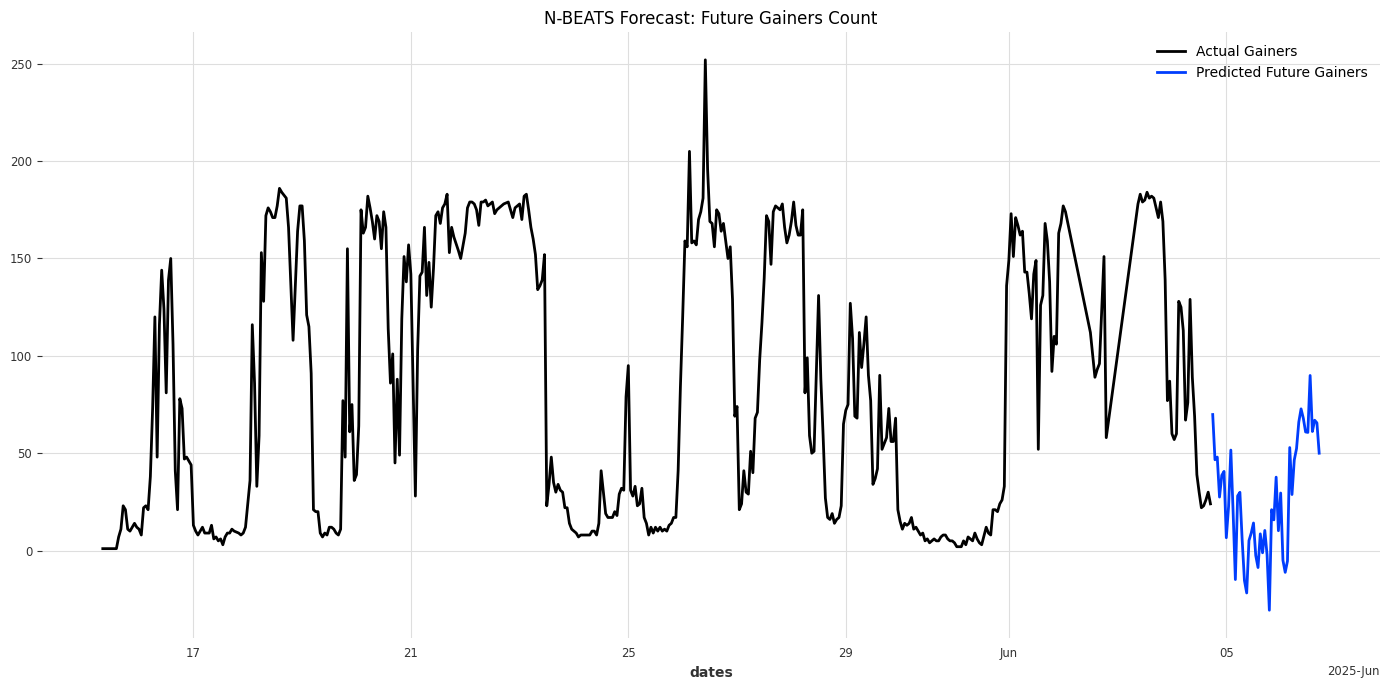

In [3]:
# Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Create TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['gainers_count'],
    fill_missing_dates=True,
    freq="h"
)

# Normalize and fill
scaler = Scaler()
filler = MissingValuesFiller()
series = filler.transform(series, method="linear")
series_scaled = scaler.fit_transform(series)

# input_chunk_length can't be increased because data needs to be 500+
input_chunk_length = 240
forecast_horizon = 48

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=200,
    # smaller means more frequent weight updates
    batch_size=16,
    # keep constant for consistency across repeated runs
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
# Remove verbose for production
model.fit(series_scaled, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Plot
# To remove in production
plt.figure(figsize=(14, 7))
series.plot(label="Actual Gainers")
future_forecast_orig.plot(label="Predicted Future Gainers")
plt.title("N-BEATS Forecast: Future Gainers Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# With Box-Cox transformation

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:6

Epoch 99: 100%|██████████| 12/12 [00:01<00:00,  6.05it/s, train_loss=0.00362]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 12/12 [00:01<00:00,  6.05it/s, train_loss=0.00362]



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]



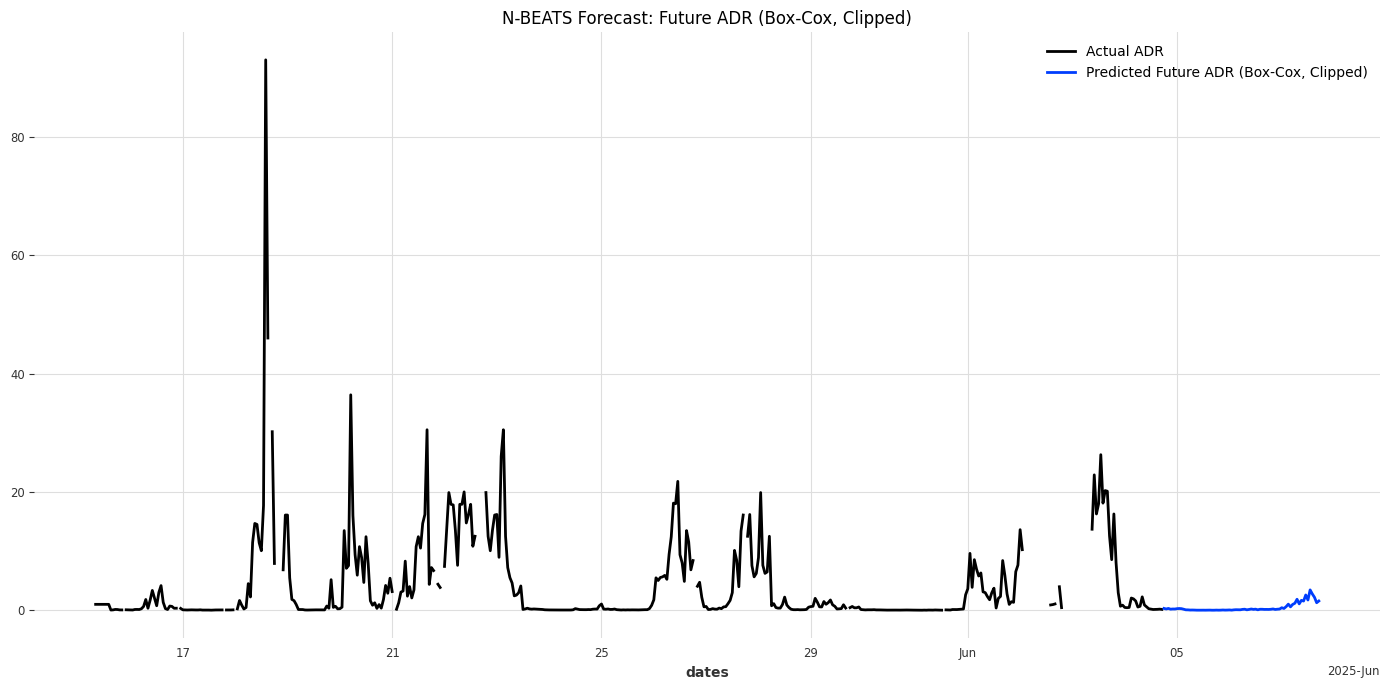

In [4]:
# ADR Forecasting using N-BEATS + Box-Cox

# Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim
import numpy as np
import torch

torch.set_default_dtype(torch.float32)  # Ensure float32 for MPS compatibility

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Calculate ADR
df['adr'] = df['gainers_count'] / df['losers_count']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['adr'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adr'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values *before* Box-Cox
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Apply Box-Cox transformation to the filled series
series_filled_values = series_filled.values().flatten()
if np.min(series_filled_values) <= 0:
    series_filled_values = series_filled_values + np.abs(np.min(series_filled_values)) + 1e-6

series_boxcox, lambda_param = boxcox(series_filled_values)
series_boxcox = TimeSeries.from_times_and_values(
    series_filled.time_index,
    series_boxcox.astype(np.float32),
    freq=series_filled.freq
)

# Normalize after Box-Cox and filling
scaler = Scaler()
series_scaled = scaler.fit_transform(series_boxcox)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=100,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
model.fit(series_scaled, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig_scaled = scaler.inverse_transform(future_forecast_scaled)

# Inverse Box-Cox transformation with float32 values
future_forecast_orig_scaled_vals = future_forecast_orig_scaled.values().flatten().astype(np.float32)
future_forecast_orig = TimeSeries.from_times_and_values(
    future_forecast_orig_scaled.time_index,
    inv_boxcox(future_forecast_orig_scaled_vals, lambda_param),
    freq=future_forecast_orig_scaled.freq
)

# Optional: Clip values
clipped_forecast_values = np.clip(future_forecast_orig.values().flatten(), 0, 10)
clipped_future_forecast = TimeSeries.from_times_and_values(
    future_forecast_orig.time_index,
    clipped_forecast_values,
    freq=future_forecast_orig.freq
)

# Plot
plt.figure(figsize=(14, 7))
series.plot(label="Actual ADR")
clipped_future_forecast.plot(label="Predicted Future ADR (Box-Cox, Clipped)")
plt.title("N-BEATS Forecast: Future ADR (Box-Cox, Clipped)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Final code using AD instead of ratio percentage diffs.
- New ADR uses percentage diffs (which is what we use for portfolio data) to make it smoother and less spiky in the extremme values.
- Removes Box-Cox because it does not work well with negative numbers.
- With this setup, clipping is also uncessary.
- Add learning rate scheduler, for gradual convergence (dynamic optimization)
- Add model evaluation (monitor how well it's learning)

In [6]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
import torch.optim as optim
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau


torch.set_default_dtype(torch.float32)  # Ensure float32 for MPS compatibility

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Z-score normalization
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Train/validation split
train, val = series_scaled[:-forecast_horizon], series_scaled[-forecast_horizon:]

# Define N-BEATS model (no scheduler, fixed learning rate)
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=500,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-3},
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 10, "factor": 0.5, "monitor": 'train_loss'}
)

# Fit model
model.fit(train, verbose=True)

# Forecast
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)
val_orig = scaler.inverse_transform(val)

# Evaluation
print("MAPE on validation set:", mape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot the actual series (including validation)
series_scaled.plot(label="Actual Normalized ADR", lw=2, color='black')

# Plot the predicted forecast after the validation set
future_forecast_scaled.plot(label="Predicted ADR (Normalized)", lw=2, color='blue')

plt.title("N-BEATS Forecast: Normalized ADR (Z-score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode

  | Name            | Type             | Params | Mode 
-----------------------------------------

Epoch 42:  14%|█▍        | 1/7 [00:00<00:01,  5.46it/s, train_loss=0.00652]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Forecast with validation

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MP

Epoch 199: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, train_loss=0.0051] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s, train_loss=0.0051]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.57it/s]
MAPE on validation set: 166.61554


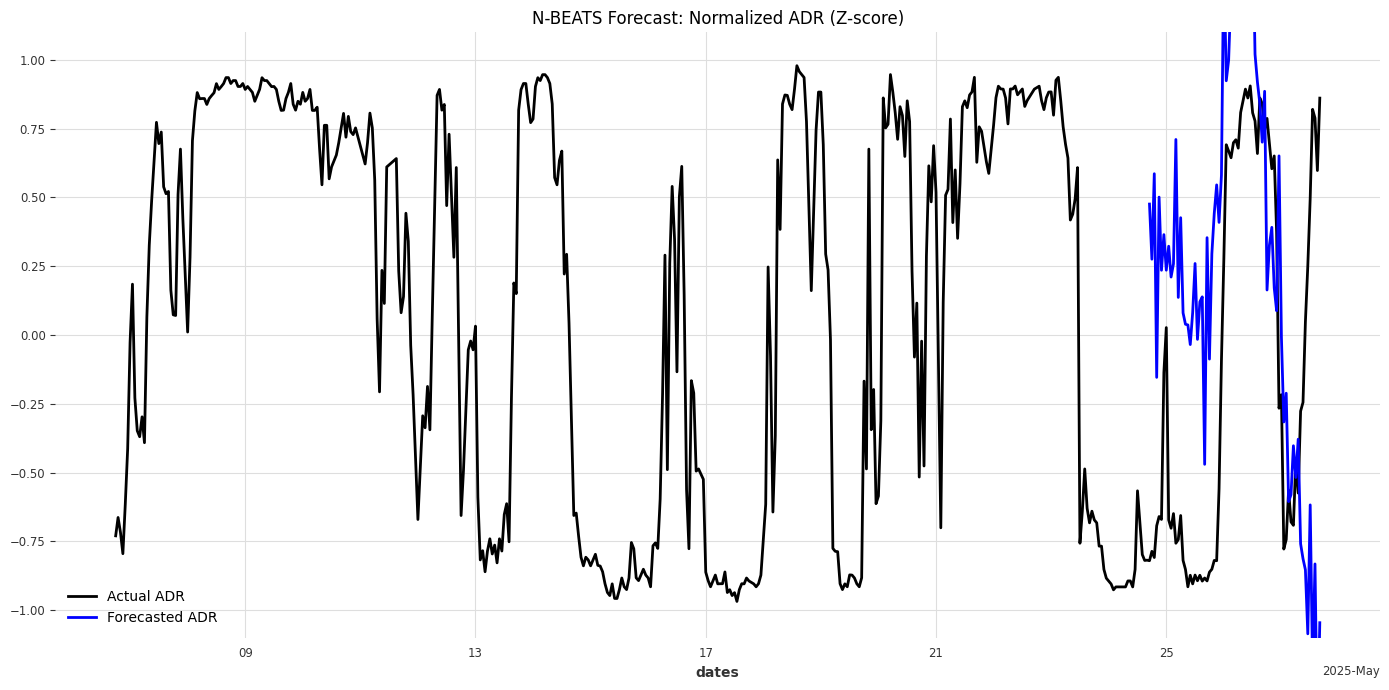

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
import torch.optim as optim
import numpy as np
import torch

torch.set_default_dtype(torch.float32)  # Ensure float32 for MPS compatibility

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Z-score normalization
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Train/validation split
train, val = series_scaled[:-forecast_horizon], series_scaled[-forecast_horizon:]
train_orig, val_orig = series_filled[:-forecast_horizon], series_filled[-forecast_horizon:]


# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=200,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}
)

# Fit model
model.fit(train, verbose=True)

# Forecast future beyond last observed point
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Validation actuals (only for MAPE calculation)
val_orig = scaler.inverse_transform(val)

# Evaluation
print("MAPE on validation set:", mape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot the combined actual data (training and validation)
series_filled.plot(label="Actual ADR", lw=2, color='black')

# Plot the forecast starting from the end of the training data
future_forecast_orig.plot(label="Forecasted ADR", lw=2, color='blue')

plt.title("N-BEATS Forecast: Normalized ADR (Z-score)")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# Production Deployment: Export Model & Predict


/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training production model on the entire dataset...



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.9 M  | train
-------------------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.622    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 799: 100%|██████████| 11/11 [00:01<00:00,  5.83it/s, train_loss=0.00626]

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 799: 100%|██████████| 11/11 [00:01<00:00,  5.82it/s, train_loss=0.00626]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Generating forecast for the next 72 periods...
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


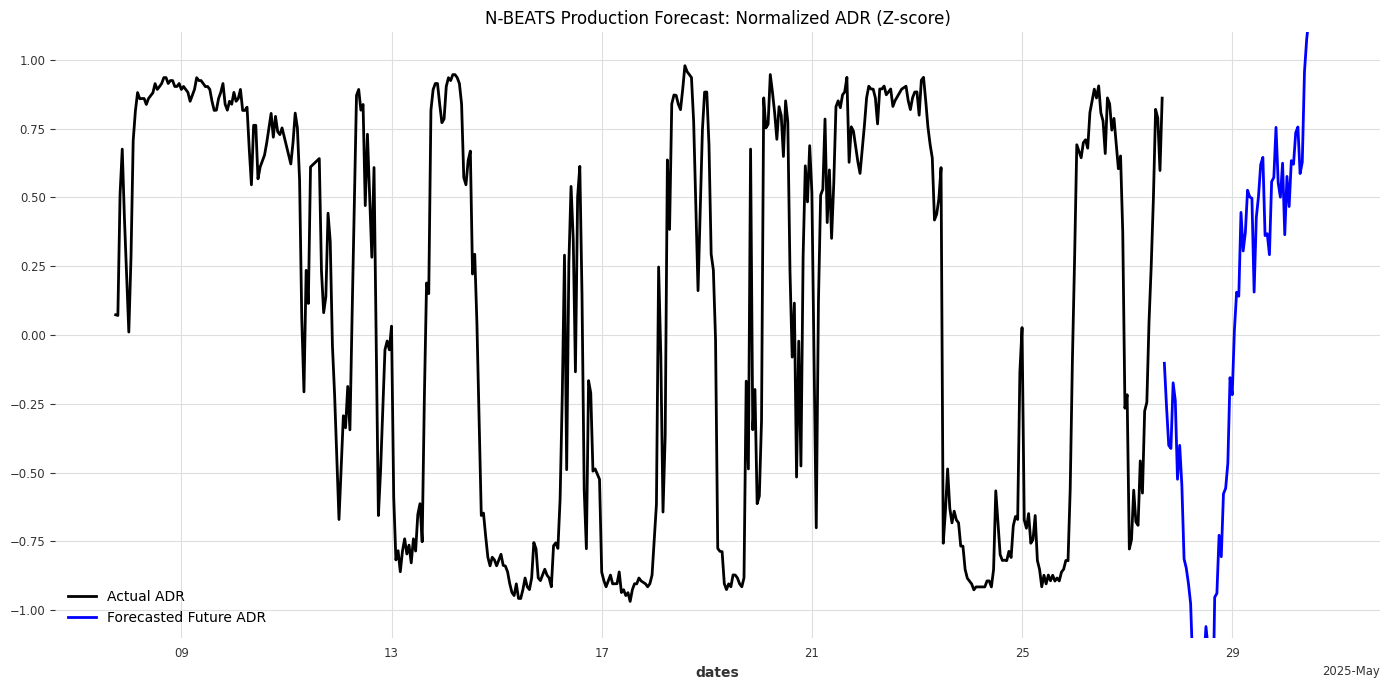

In [ ]:

import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import torch.optim as optim
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float32)

# Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Clean and preprocess
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature engineering
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df['adp'] = (df['gainers_count'] - df['losers_count']) / (df['gainers_count'] + df['losers_count'])

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(
    df,
    value_cols=['adp'],
    fill_missing_dates=True,
    freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")

# Z-score normalization
scaler = Scaler()
series_scaled = scaler.fit_transform(series_filled)

# Parameters
input_chunk_length = 240
forecast_horizon = 72

# Define N-BEATS model with optimized hyperparameters (assuming you found them during development)
# Use the best hyperparameters determined from your experimentation with the validation set
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=600,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4}, # Use the optimized learning rate
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 10, "factor": 0.5, "monitor": 'train_loss'}
)

# Fit model on the entire scaled series for production
print("Training production model on the entire dataset...")
model.fit(series_scaled, verbose=True)

# Forecast into the future from the end of the entire series
print(f"Generating forecast for the next {forecast_horizon} periods...")
future_forecast_scaled = model.predict(n=forecast_horizon)
future_forecast_orig = scaler.inverse_transform(future_forecast_scaled)

# Plot the entire actual series and the future forecast
plt.figure(figsize=(14, 7))

# Plot the entire actual series
series_filled.plot(label="Actual ADR", lw=2, color='black')

# Plot the future forecast extending from the end of the actual data
future_forecast_orig.plot(label="Forecasted Future ADR", lw=2, color='blue')

plt.title("N-BEATS Production Forecast: Normalized ADR (Z-score)")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# You can now use future_forecast_orig for your predictions

# Optional: Save the production model
# model.save_model('nbeats_adr_production_model.pth')

# Final model with covariates total_volume and MAs

- Uses 500 epochs (which seems to provide a better fit). Adjust as necessary when running locally
-  

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
3.7 K     Non-trainable params
9.2 M     Total params
36.669    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:6

Epoch 499: 100%|██████████| 18/18 [00:03<00:00,  5.79it/s, train_loss=0.0025] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 18/18 [00:03<00:00,  5.79it/s, train_loss=0.0025]



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s]
SMAPE on validation set: 88.233665

SMAPE on validation set: 88.233665


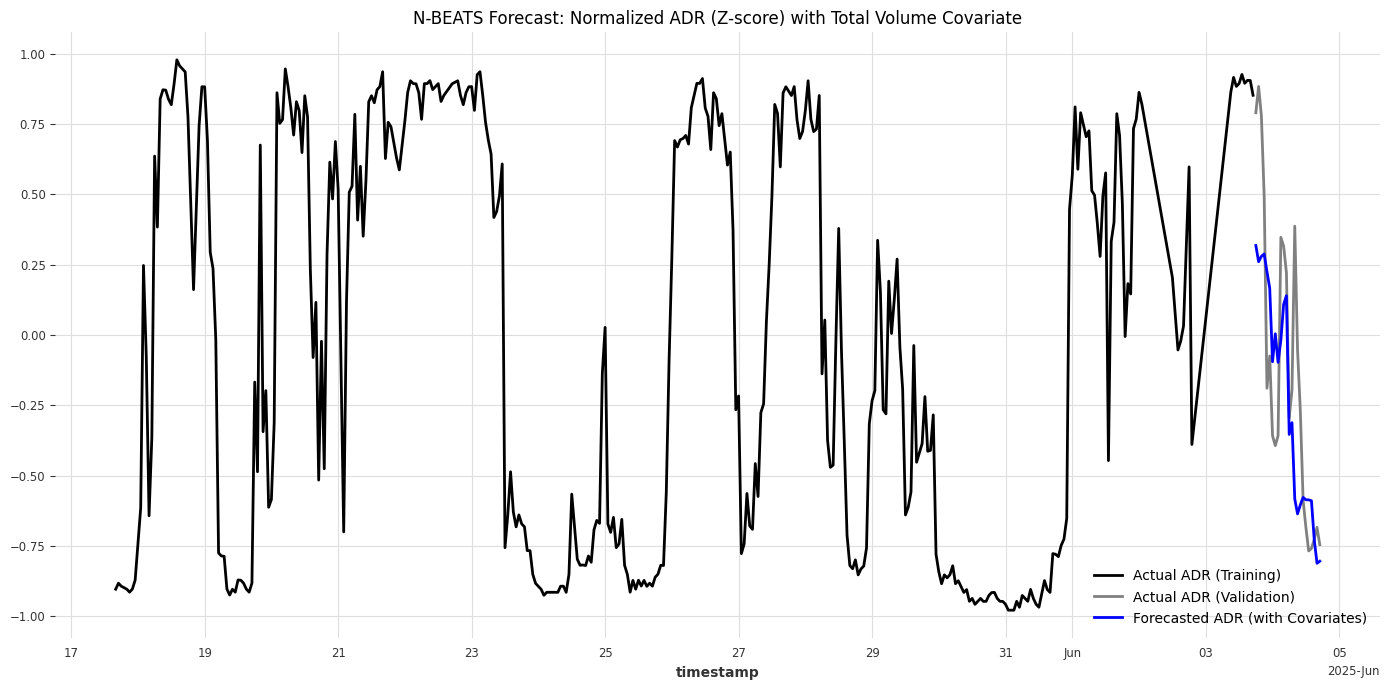

In [38]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import smape
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Fetch data (same as before)
# Fetch data (production endpoint)
url = "https://api.terminal.binbot.in/charts/adr-series?size=400"
data = requests.get(url).json()
df = pd.DataFrame(data["data"])

# Clean and preprocess
# Use only columns required for inference
# (Assumes columns: timestamp, advancers, decliners, total_volume)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)


# Feature engineering
df["advancers"] = df["advancers"].astype("float32")
df["decliners"] = df["decliners"].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")
df["adp"] = df["adp"].astype("float32")
df["adp_ma"] = df["adp_ma"].astype("float32")

# Add moving averages if required by the model
df["adp_ma7"] = df["adp"].rolling(7).mean().astype("float32")

df.dropna(inplace=True)

# Convert to Darts TimeSeries (let Darts infer frequency)
series = TimeSeries.from_dataframe(df, value_cols=["adp"], fill_missing_dates=True, freq="h")
covariate_series = TimeSeries.from_dataframe(
    df,
    value_cols=["total_volume", "adp_ma", "adp_ma7"],
    fill_missing_dates=True, freq="h"
)

# Fill missing values for both series and covariate series
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")
covariate_series_filled = filler.transform(covariate_series, method="linear")

# Z-score normalization for both series and covariate series
scaler_series = Scaler()
scaler_covariate = Scaler()
series_scaled = scaler_series.fit_transform(series_filled)
covariate_series_scaled = scaler_covariate.fit_transform(covariate_series_filled)

# Parameters
input_chunk_length = 100
forecast_horizon = 24

# Train/validation split for both series and covariate series
train_scaled, val_scaled = (
    series_scaled[:-forecast_horizon],
    series_scaled[-forecast_horizon:],
)
train_orig, val_orig = (
    series_filled[:-forecast_horizon],
    series_filled[-forecast_horizon:],
)
train_covariate_scaled = covariate_series_scaled[:-forecast_horizon]

# Define N-BEATS model with future covariates
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=500,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4},
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 15, "factor": 0.5, "monitor": "train_loss"},
)

# Fit model with future covariates
model.fit(train_scaled, past_covariates=covariate_series_scaled, verbose=True)

# Forecast beyond training data using the last available covariate window
future_covariates = covariate_series_scaled[
    -(input_chunk_length + forecast_horizon) :
]


future_forecast_scaled = model.predict(
    n=forecast_horizon, past_covariates=future_covariates
)

# Convert forecast to original scale
future_forecast_orig = scaler_series.inverse_transform(future_forecast_scaled)

# Extract the corresponding portion of actual series for validation
val_orig = series_filled[-forecast_horizon:]

# Evaluation (using the original scale validation data)
print("SMAPE on validation set:", smape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot actual normalized ADR for training and validation periods
train_orig.plot(label="Actual ADR (Training)", lw=2, color="black")
val_orig.plot(label="Actual ADR (Validation)", lw=2, color="gray")

# Plot forecast extending from the end of the training data
future_forecast_orig.plot(label="Forecasted ADR (with Covariates)", lw=2, color="blue")

model.save("dist/market_breadth_nbeats_model_v1.pth")

plt.title("N-BEATS Forecast: Normalized ADR (Z-score) with Total Volume Covariate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Production Inference: Predict Market Breadth with N-BEATS

This notebook cell is for production use only. It loads a pre-trained N-BEATS model, preprocesses new data, and outputs the latest forecast. All training and experimentation code has been removed.

- Load model
- Preprocess data
- Predict
- Output results

In [ ]:
# Production prediction script for N-BEATS model with covariates
import pandas as pd
import requests
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import NBEATSModel
import torch

torch.set_default_dtype(torch.float32)

# Load the saved model
model = NBEATSModel.load("dist/market_breadth_nbeats_model_v1.pth")

# Fetch data (production endpoint)
url = "https://api.terminal.binbot.in/charts/adr-series?size=700"
data = requests.get(url).json()
df = pd.DataFrame(data["data"])

# Clean and preprocess
# Use only columns required for inference
# (Assumes columns: timestamp, advancers, decliners, total_volume)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep='last')]

# Feature engineering
df["diff"] = (df["advancers"] - df["decliners"]).astype("float32")
df["advancers"] = df["advancers"].astype("float32")
df["decliners"] = df["decliners"].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df["adp"] = (df["diff"] / (df["advancers"] + df["decliners"])).astype("float32")

# Add moving averages if required by the model
df["adp_ma7"] = df["adp"].rolling(7).mean().astype("float32")

df.dropna(inplace=True)

# Ensure all columns used for inference are float32
float32_cols = ["total_volume", "adp_ma", "adp_ma7", "adp"]
for col in float32_cols:
    if col in df.columns:
        df[col] = df[col].astype("float32")

# --- Extend covariates into the future ---
input_chunk_length = 240
forecast_horizon = 72

# Create a future index for the forecast horizon
last_timestamp = df.index[-1]
freq = pd.infer_freq(df.index)
if freq is None:
    freq = 'H'  # fallback to hourly
future_index = pd.date_range(start=last_timestamp + pd.Timedelta(1, unit='h'), periods=forecast_horizon, freq=freq)

# Forward-fill the last row for covariates
future_covariates_df = pd.DataFrame(
    [df.iloc[-1][["total_volume", "adp_ma", "adp_ma7"]].values] * forecast_horizon,
    columns=["total_volume", "adp_ma", "adp_ma7"],
    index=future_index
)

# Append to the original DataFrame for covariates
covariate_df_full = pd.concat([
    df[["total_volume", "adp_ma", "adp_ma7"]],
    future_covariates_df
])

# Create TimeSeries for target and covariates
series = TimeSeries.from_dataframe(df, value_cols=["adp"], fill_missing_dates=True, freq="h")
covariate_series = TimeSeries.from_dataframe(
    covariate_df_full,
    value_cols=["total_volume", "adp_ma", "adp_ma7"],
    fill_missing_dates=True, freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")
covariate_series_filled = filler.transform(covariate_series, method="linear")

# Z-score normalization (fit on all available data)
scaler_series = Scaler()
scaler_covariate = Scaler()
series_scaled = scaler_series.fit_transform(series_filled)
covariate_series_scaled = scaler_covariate.fit_transform(covariate_series_filled)

# Use the latest available covariates for prediction
future_covariates = covariate_series_scaled[-(input_chunk_length + forecast_horizon):]

# Predict
y_pred_scaled = model.predict(n=forecast_horizon, past_covariates=future_covariates)
y_pred = scaler_series.inverse_transform(y_pred_scaled)

# Output forecast as DataFrame
forecast_df = y_pred.to_dataframe()
latest_prediction = forecast_df.iloc[-1]["adp"]
print("Latest forecasted adp:", latest_prediction)

/var/folders/jf/bv5tm1xj0gl2z7_bb3q05rgm0000gn/T/ipykernel_20054/3627886188.py:61: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=last_timestamp + pd.Timedelta(1, unit='h'), periods=forecast_horizon, freq=freq)
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]
Latest forecasted adp: -1.143064

Latest forecasted adp: -1.143064
